In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import umap
import hdbscan

In [2]:
#load dataframe of news articles
text_df = pd.read_csv('./news_articles.csv')
text_df.head(2)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."


In [3]:
avg_title_length = text_df['title'].apply(lambda article: len(article)).mean()
print(f"Average title word length: {int(avg_title_length):,}")
avg_article_length = text_df['content'].apply(lambda article: len(article)).mean()
print(f"Average article word length: {int(avg_article_length):,}")

Average title word length: 71
Average article word length: 3,853


In [4]:
#set name of dataframe column we want to model
column_to_cluster = 'title'
data = text_df[column_to_cluster]

Create Sentence Embeddings and Cluster

In [5]:
model = SentenceTransformer('all-mpnet-base-v2')

In [6]:
#create sentence embeddings
embeddings = model.encode(data, show_progress_bar=True)
print(f"Shape of embeddings: {embeddings[0].shape}")

Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Shape of embeddings: (768,)


In [7]:
#reduce dimensionality using umap
reducer = umap.UMAP(n_neighbors=15, #size of the local neighborhood
                    n_components=5, #number of parameters to reduce to
                    metric='cosine')
umap_embeddings = reducer.fit_transform(embeddings)

In [8]:
#cluster the embeddings with hdbscan
#hdbscan automatically identifies cluster amount using areas high density with respect to the sentence embeddings
cluster = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean',
                          cluster_selection_method='eom')
#fit our reduced dimensionality embeddings
clusters = cluster.fit(umap_embeddings)

In [9]:
%matplotlib inline

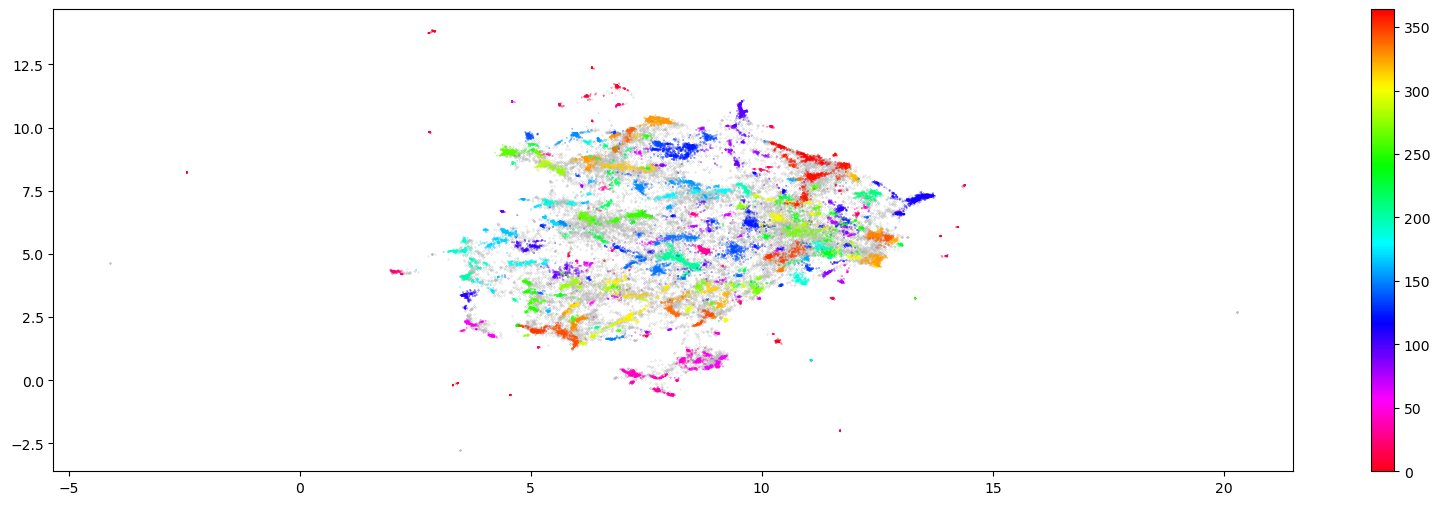

In [10]:
import matplotlib.pyplot as plt

#map our sentence embeddings to 2 dimensions
umap_data = umap.UMAP(n_neighbors=15, n_components=2,
                      min_dist=0.0, metric='cosine').fit_transform(embeddings)
#store in dataframe and add cluster labels from hdbscan
results = pd.DataFrame(umap_data, columns=['x', 'y'])
results['label'] = clusters.labels_

#plot clusters in 2-D
fig, ax = plt.subplots(figsize=(20, 6))
outliers = results.loc[results['label']==-1, :]
clustered = results.loc[results['label']!=-1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.label, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.show()

Create Topic Model

In [11]:
#create our own tfidf function
def class_based_tf_idf(documents, doc_count, ngram_range=(1, 1)):
    """
    Compute class based tf-idf to supply documents within the same label or class (cluster) the same class vector.
    """
    #ngram count from documents
    count = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(documents)
    
    #term frequency by cluster
    t = count.transform(documents).toarray()
    #total number of words per topic
    w = t.sum(axis=1)
    #term frequency divided by word count
    tf = np.divide(t.T, w)
    #total word frequency of entire corpus
    sum_t = t.sum(axis=0)
    
    #inverse document frequency
    idf = np.log(np.divide(doc_count, sum_t)).reshape(-1, 1)
    #multiple term frequency by inverse document frequency
    tf_idf = np.multiply(tf, idf)
    return tf_idf, count

In [12]:
#cluster labes in document dataframe
text_df['Topic'] = clusters.labels_
#create document id key
text_df['ID'] = range(len(text_df))
#groupby cluster and combine all article text in one row
all_topic_text = text_df.groupby(['Topic'], as_index=False).agg({column_to_cluster: ' '.join})

#calculate tfidf and total count
tf_idf, cv = class_based_tf_idf(all_topic_text[column_to_cluster].values, doc_count=len(data))

In [13]:
def topic_top_n_words(tfidf, fit_vectorizer, topic_df, n=20):
    """
    Extract top n most important words per topic based on class tfidf vector.
    """
    #get word labels from vectorizer
    words = fit_vectorizer.get_feature_names_out()
    
    #list of cluster labels (topics)
    labels = list(topic_df['Topic'])
    #transpose tfidf to represent topics in rows and word score in columns
    tfidf_trans = tfidf.T
    #return sorted indices based on importance (low to high) and take last n
    indices = tfidf_trans.argsort()[:, -n:]
    
    #return dictionary with topic label and the top n words per topic with importance score
    top_n_words = {label: [(words[j], tfidf_trans[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def topic_sizes(df):
    """
    Count of articles per topic in a dataframe.
    """
    topic_size = df.groupby(['Topic'], as_index=False)[column_to_cluster].count()\
                   .rename(columns={column_to_cluster:'Size'}).sort_values('Size', ascending=False)
    return topic_size

In [14]:
#most important words per cluster (topic)
top_n_words = topic_top_n_words(tf_idf, cv, all_topic_text, n=20)
#size of each topic
size = topic_sizes(text_df)

#get largest 10 topics (if there are 10) excluding noise (-1)
top_topics = size.loc[size['Topic']!=-1][:10]['Topic'].tolist()
print(top_topics)
print('\n')
[print(f"{topic}: {[tup[0] for tup in top_n_words[topic]]}\n\n") for topic in top_topics]

[125, 113, 202, 96, 263, 254, 326, 345, 325, 93]


125: ['israel', 'israeli', 'netanyahu', 'palestinian', 'jewish', 'anti', 'jerusalem', 'trump', 'embassy', 'semitism', 'palestinians', 'hamas', 'jews', 'resolution', 'breitbart', 'settlements', 'new', 'york', 'obama', 'times']


113: ['obamacare', 'health', 'care', 'repeal', 'gop', 'healthcare', 'house', 'republicans', 'ryan', 'paul', 'plan', 'replacement', 'breitbart', 'insurance', 'trump', 'times', 'york', 'new', 'caucus', 'rep']


202: ['milo', 'breitbart', 'university', 'berkeley', 'yiannopoulos', 'speech', 'uc', 'students', 'free', 'college', 'event', 'student', 'campus', 'twitter', 'professor', 'protesters', 'coulter', 'ann', 'watch', 'depaul']


96: ['korea', 'north', 'korean', 'south', 'missile', 'kim', 'jong', 'nuclear', 'test', 'nam', 'new', 'times', 'york', 'ballistic', 'china', 'says', 'president', 'fires', 'missiles', 'launch']


263: ['brexit', 'britain', 'farage', 'eu', 'uk', 'theresa', 'vote', 'new', 'ukip', 'referendum'

[None, None, None, None, None, None, None, None, None, None]

Reduce Topic Dimensionality if Desired

In [15]:
def reduce_topic_dimensionality(clusters_to_remove, tfidf, countvec, text_dataframe):
    """
    Combine the smallest cluster with its highest similarity cluster and then recreate the topic model.
    Iterate X times until we have removed a set number of clusters.
    """
    for i in range(clusters_to_remove):
        #compute similarity between each topic
        similarities = cosine_similarity(tfidf.T)
        #make the diagonal of the make 0, (set topic similarity with itself to 0)
        np.fill_diagonal(similarities, 0)
        
        #get topic size
        topic_size = topic_sizes(text_dataframe)
        
        #index of smallest topic
        topic_being_merged = topic_size.iloc[-1]['Topic']
        #highest similarity topic
        topic_merged_to = np.argmax(similarities[topic_being_merged + 1]) - 1
        
        #adjust the dataframe topics
        text_dataframe['Topic'] = [topic_merged_to if top == topic_being_merged else top for top in text_dataframe['Topic']]
        
        #create topic map to change topic numbers
        old_topics = text_dataframe['Topic'].sort_values().unique()
        topic_map = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
        #map to new topic numbers
        text_dataframe['Topic'] = text_dataframe['Topic'].map(topic_map)
        #aggregate document text by topic again
        all_topic_text = text_dataframe.groupby(['Topic'], as_index=False).agg({column_to_cluster: ' '.join})
        
        #recreate topic model
        doc_count = len(text_dataframe)
        tfidf, countvec = class_based_tf_idf(all_topic_text[column_to_cluster].values, doc_count)
        top_n_words = topic_top_n_words(tfidf, countvec, all_topic_text, n=20)
    return text_dataframe, tfidf, countvec, top_n_words

In [16]:
new_text_df, new_tfidf, new_cv, new_top_words = reduce_topic_dimensionality(20, tf_idf, cv, text_df)

In [17]:
#size of each topic
size = topic_sizes(new_text_df)

#get largest 10 topics (if there are 10) excluding noise (-1)
top_topics = size.loc[size['Topic']!=-1][:10]['Topic'].tolist()
print(top_topics)
print('\n')
[print(f"{topic}: {[tup[0] for tup in new_top_words[topic]]}\n\n") for topic in top_topics]

[116, 104, 190, 89, 247, 238, 308, 326, 307, 86]


116: ['israel', 'israeli', 'netanyahu', 'palestinian', 'jewish', 'anti', 'jerusalem', 'trump', 'embassy', 'semitism', 'palestinians', 'hamas', 'jews', 'resolution', 'breitbart', 'settlements', 'new', 'york', 'obama', 'times']


104: ['obamacare', 'health', 'care', 'repeal', 'gop', 'healthcare', 'house', 'republicans', 'ryan', 'paul', 'plan', 'replacement', 'breitbart', 'insurance', 'trump', 'times', 'york', 'new', 'caucus', 'rep']


190: ['milo', 'breitbart', 'university', 'berkeley', 'yiannopoulos', 'speech', 'uc', 'students', 'free', 'college', 'event', 'student', 'campus', 'twitter', 'professor', 'protesters', 'coulter', 'ann', 'watch', 'depaul']


89: ['korea', 'north', 'korean', 'south', 'missile', 'kim', 'jong', 'nuclear', 'test', 'nam', 'new', 'times', 'york', 'ballistic', 'china', 'says', 'president', 'fires', 'missiles', 'launch']


247: ['brexit', 'britain', 'farage', 'eu', 'uk', 'theresa', 'vote', 'new', 'ukip', 'referendum'

[None, None, None, None, None, None, None, None, None, None]

Use Topic Model Class We Created

In [4]:
import pandas as pd

In [5]:
from MPNETopic import MPNETopic

In [ ]:
#re-load dataframe of news articles
text_df = pd.read_csv('./news_articles.csv')
column='title'

topic_model = MPNETopic(text_df, column)
topics = topic_model.create_topic_model()

Average title word length: 71



Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

In [ ]:
print(topics[196])